## LAB3 A: 3D CNN

### Proceedure:

- Create appropriate `DataLoader` for ease of use throughout the notebook.
- No pretrained backbone for this notebook, train from scratch and evaluate for these setups:
    - 3D CNN with InceptionNet (parallel) style 3x3 convs.
    - 3D CNN with InceptionNet (parallel) style 5x5 convs.
    - 3D CNN with sequential style 3x3 convs.
    - 3D CNN with SlowFast paths (3x3 convs).

In [11]:
import os
conda_bin = r"E:\Miniconda\envs\acv_tf\Library\bin"
os.environ['PATH'] = conda_bin + os.pathsep + os.environ['PATH']

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, 
                                     LeakyReLU, Flatten, Dense, Add, Concatenate,
                                     Dropout, BatchNormalization, GlobalAveragePooling3D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.1
Num GPUs Available: 1


In [12]:
class VideoDataset:
    def __init__(self, root_dir, split="train", num_frames=16,
                 slowfast=False, slow_num_frames=8, fast_num_frames=32):
        self.split = split
        self.num_frames = num_frames
        self.slowfast = slowfast
        self.slow_num_frames = slow_num_frames
        self.fast_num_frames = fast_num_frames

        # 🔹 Load npz file
        npz_path = os.path.join(root_dir, f"{split}.npz")
        data = np.load(npz_path, allow_pickle=True)

        self.videos = data["X"]     # object array of videos
        self.labels = data["y"]     # numeric labels
        self.ids = data["ids"]      # ["class/video", ...]

        # 🔹 Build class map from ids
        all_classes = sorted({vid.split("/")[0] for vid in self.ids})
        self.class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

        print(f"✅ Loaded {split}.npz: {len(self.videos)} samples, {len(all_classes)} classes")

    def _uniform_sample(self, frames, num_samples):
        n = len(frames)
        if n >= num_samples:
            idxs = np.linspace(0, n - 1, num_samples).astype(int)
            return frames[idxs]
        else:
            # pad with black frames (left side)
            pad_len = num_samples - n
            pad = np.zeros((pad_len, frames.shape[1], frames.shape[2], frames.shape[3]),
                           dtype=frames.dtype)
            return np.concatenate([pad, frames], axis=0)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = self.videos[idx]   # (T, H, W, C)
        label = int(self.labels[idx])
        class_name = self.idx_to_class[label]   # map back to readable name

        if self.slowfast:
            slow = self._uniform_sample(frames, self.slow_num_frames)
            fast = self._uniform_sample(frames, self.fast_num_frames)
            return ((slow.astype(np.float32) / 255.0,
                     fast.astype(np.float32) / 255.0),
                    label, class_name)
        else:
            sampled = self._uniform_sample(frames, self.num_frames)
            return (sampled.astype(np.float32) / 255.0), label, class_name


# 🔹 Wrap into tf.data.Dataset
def make_tf_dataset(dataset: VideoDataset, batch_size=4, shuffle=True):
    def gen():
        for i in range(len(dataset)):
            yield dataset[i]

    output_types = ((tf.float32, tf.float32) if dataset.slowfast else tf.float32,
                    tf.int32, tf.string)
    output_shapes = (((dataset.slow_num_frames, 112, 112, 3),
                      (dataset.fast_num_frames, 112, 112, 3)) if dataset.slowfast
                     else (dataset.num_frames, 112, 112, 3),
                     (), ())

    ds = tf.data.Dataset.from_generator(gen, output_types=output_types, output_shapes=output_shapes)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataset))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [25]:
class VideoModelBuilder:
    """
    Builds and compiles small 3D-CNN variants:
      - inception_3x3 : inception-style parallel branches, use 3x3 within branches
      - inception_5x5 : same but with 5x5 convs in branches
      - sequential     : stacked convs roughly matching the same scale
      - slowfast       : two-path (slow=8, fast=16), concat merge
    """
    def __init__(self, input_shape, num_classes, base_filters=16, lr=1e-3):
        # input_shape: for single-stream approaches -> (T, H, W, C)
        #              for slowfast we pass None and builder will expect two inputs
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.base_filters = base_filters
        self.lr = lr

    def build(self, approach="inception_3x3"):
        if approach == "inception_3x3":
            model = self._build_inception(kernel_size=3)
        elif approach == "inception_5x5":
            model = self._build_inception(kernel_size=5)
        elif approach == "sequential":
            model = self._build_sequential()
        elif approach == "slowfast":
            model = self._build_slowfast(slow_frames=8, fast_frames=16)
        else:
            raise ValueError(f"Unknown approach: {approach}")

        # Compile ready-to-train: sparse CE (loader returns integer labels)
        model.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss=SparseCategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        return model

    def _initial_block(self, inp, filters):
        x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(inp)
        x = LeakyReLU(alpha=0.001)(x)
        x = Conv3D(filters*2, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        return x

    def _inception_branch(self, x, mid_filters, kernel_size):
        b = Conv3D(mid_filters, kernel_size=(1,1,1), padding='same')(x)
        b = LeakyReLU(alpha=0.001)(b)
        b = Conv3D(mid_filters, kernel_size=(kernel_size,kernel_size,kernel_size), padding='same')(b)
        b = LeakyReLU(alpha=0.001)(b)
        b = Conv3D(mid_filters*2, kernel_size=(1,1,1), padding='same')(b)
        b = LeakyReLU(alpha=0.001)(b)
        b = MaxPooling3D(pool_size=(2,2,2), padding='same')(b)
        return b

    def _build_inception(self, kernel_size=3):
        # Single-stream version
        inp = Input(shape=self.input_shape, name="video_in")
        x = self._initial_block(inp, self.base_filters)

        b1 = self._inception_branch(x, mid_filters=self.base_filters, kernel_size=kernel_size)
        b2 = self._inception_branch(x, mid_filters=self.base_filters//2, kernel_size=kernel_size)
        b3 = self._inception_branch(x, mid_filters=max(1, self.base_filters//4), kernel_size=kernel_size)

        merged = Concatenate(axis=-1)([b1, b2, b3])
        merged = MaxPooling3D(pool_size=(2,2,2), padding='same')(merged)

        # pooling -> global pool -> dense
        pooled = GlobalAveragePooling3D()(merged)
        d = Dense(256, activation='relu')(pooled)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=inp, outputs=out, name=f"inception_{kernel_size}x{kernel_size}")
        return model

    def _build_sequential(self):
        inp = Input(shape=self.input_shape, name="video_in")
        # A sequential stack roughly matching scale of inception
        x = Conv3D(self.base_filters, kernel_size=(3,3,3), padding='same')(inp)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = Conv3D(self.base_filters*4, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = GlobalAveragePooling3D()(x)
        d = Dense(256, activation='relu')(x)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=inp, outputs=out, name="sequential_3dcnn")
        return model

    def _build_slowfast(self, slow_frames=8, fast_frames=16):
        # slow and fast inputs must be provided to model as two separate inputs
        slow_in = Input(shape=(slow_frames, self.input_shape[1], self.input_shape[2], self.input_shape[3]), name="slow_in")
        fast_in = Input(shape=(fast_frames, self.input_shape[1], self.input_shape[2], self.input_shape[3]), name="fast_in")

        # slow path: fewer frames, deeper channels
        s = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(slow_in)
        s = LeakyReLU(alpha=0.001)(s)
        s = MaxPooling3D(pool_size=(2,2,2), padding='same')(s)
        s = Conv3D(self.base_filters*4, kernel_size=(3,3,3), padding='same')(s)
        s = LeakyReLU(alpha=0.001)(s)
        s = GlobalAveragePooling3D()(s)

        # fast path: more frames, fewer channels
        f = Conv3D(self.base_filters, kernel_size=(3,3,3), padding='same')(fast_in)
        f = LeakyReLU(alpha=0.001)(f)
        f = MaxPooling3D(pool_size=(2,2,2), padding='same')(f)
        f = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(f)
        f = LeakyReLU(alpha=0.001)(f)
        f = GlobalAveragePooling3D()(f)

        # merge
        merged = Concatenate()([s, f])
        d = Dense(256, activation='relu')(merged)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=[slow_in, fast_in], outputs=out, name="slowfast_simple")
        return model

In [14]:
ROOT = "data/UCF50_npz"
BATCH = 16

# instantiate dataset objects (train + val)
train_ds_src = VideoDataset(ROOT, split="train", num_frames=16, slowfast=False)
val_ds_src   = VideoDataset(ROOT, split="test",   num_frames=16, slowfast=False)

# convert to tf.data
train_tf = make_tf_dataset(train_ds_src, batch_size=BATCH, shuffle=True)
val_tf   = make_tf_dataset(val_ds_src, batch_size=BATCH, shuffle=False)

# If you want to run slowfast experiments:
# train_ds_sfsrc = VideoDataset(ROOT, split="train", slowfast=True, slow_num_frames=8, fast_num_frames=16)
# train_tf_slowfast = make_tf_dataset(train_ds_sfsrc, batch_size=BATCH, shuffle=True)

# Helper to map dataset items (remove the class_name string) so Keras receives (inputs, labels)
def tf_for_keras(ds, slowfast=False):
    if slowfast:
        # ds yields: ((slow, fast), label, class_name)
        def _map(slowfast_in, label, cname):
            return ({"slow_in": slowfast_in[0], "fast_in": slowfast_in[1]}, label)
        return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # ds yields: (frames, label, class_name)
        def _map(frames, label, cname):
            return (frames, label)
        return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

# Example: keras-ready datasets
train_keras = tf_for_keras(train_tf, slowfast=False)
val_keras   = tf_for_keras(val_tf, slowfast=False)

✅ Loaded train.npz: 524 samples, 5 classes
✅ Loaded test.npz: 132 samples, 5 classes


### Inception-style 3D CNN with 3x3 filters

In [15]:
APPROACH = "inception_3x3"   # options: "inception_3x3", "inception_5x5", "sequential", "slowfast"
EPOCHS = 5
BATCH = 16

# Determine input shape from a single sample
# We use the dataset source object (train_ds_src) to get shapes:
if APPROACH == "slowfast":
    input_shape = (None, 112, 112, 3)  # we'll pass frames counts in builder when building slowfast
else:
    # single stream shape: (T, H, W, C)
    input_shape = (train_ds_src.num_frames, 112, 112, 3)

num_classes = len(train_ds_src.idx_to_class)

builder = VideoModelBuilder(input_shape=input_shape, num_classes=num_classes, base_filters=16)
model = builder.build(approach=APPROACH)
model.summary()

# select appropriate tf datasets for Keras fit
if APPROACH == "slowfast":
    # replace with slowfast datasets if you created them
    train_ready = tf_for_keras(train_tf, slowfast=True)
    val_ready = tf_for_keras(val_tf, slowfast=True)
else:
    train_ready = train_keras
    val_ready = val_keras

# callbacks: light checkpointing
ckpt_cb = tf.keras.callbacks.ModelCheckpoint("models/inception_3x3.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    train_ready,
    validation_data=val_ready,
    epochs=EPOCHS,
    callbacks=[ckpt_cb],
    verbose=2
)

Model: "inception_3x3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv3d_33 (Conv3D)             (None, 16, 112, 112  1312        ['video_in[0][0]']               
                                , 16)                                                             
                                                                                                  
 leaky_re_lu_33 (LeakyReLU)     (None, 16, 112, 112  0           ['conv3d_33[0][0]']              
                                , 16)                                                 

Validation accuracy: 0.5833
Confusion matrix (rows=true, cols=pred):
[[17 12  1  0  0]
 [ 2 24  1  0  2]
 [ 7  2 10  0  9]
 [ 4  0  8 11  2]
 [ 0  2  3  0 15]]
Class index -> name mapping:
0 BaseballPitch
1 GolfSwing
2 Lunges
3 PommelHorse
4 Skijet


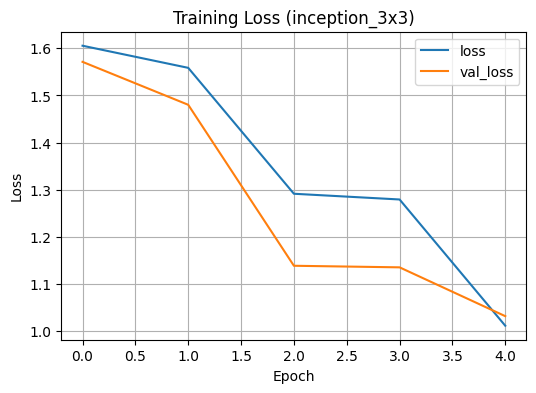

In [16]:
# Load best weights if saved
if os.path.exists("models/inception_3x3.h5"):
    model.load_weights("models/inception_3x3.h5")

# Build arrays of true labels and predicted labels on validation set
y_true = []
y_pred = []

# val_ready yields (inputs, labels)
for batch_inputs, batch_labels in val_ready:
    preds = model.predict(batch_inputs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Print class mapping for clarity
print("Class index -> name mapping:")
for i, cname in train_ds_src.idx_to_class.items():
    print(i, cname)

# Plot loss + val_loss from history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"Training Loss ({APPROACH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Inception-style 3D CNN with 5x5 filters

In [17]:
APPROACH = "inception_5x5"   # options: "inception_3x3", "inception_5x5", "sequential", "slowfast"
EPOCHS = 5
BATCH = 16

# Determine input shape from a single sample
# We use the dataset source object (train_ds_src) to get shapes:
if APPROACH == "slowfast":
    input_shape = (None, 112, 112, 3)  # we'll pass frames counts in builder when building slowfast
else:
    # single stream shape: (T, H, W, C)
    input_shape = (train_ds_src.num_frames, 112, 112, 3)

num_classes = len(train_ds_src.idx_to_class)

builder = VideoModelBuilder(input_shape=input_shape, num_classes=num_classes, base_filters=16)
model = builder.build(approach=APPROACH)
model.summary()

# select appropriate tf datasets for Keras fit
if APPROACH == "slowfast":
    # replace with slowfast datasets if you created them
    train_ready = tf_for_keras(train_tf, slowfast=True)
    val_ready = tf_for_keras(val_tf, slowfast=True)
else:
    train_ready = train_keras
    val_ready = val_keras

# callbacks: light checkpointing
ckpt_cb = tf.keras.callbacks.ModelCheckpoint("models/inception_5x5.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    train_ready,
    validation_data=val_ready,
    epochs=EPOCHS,
    callbacks=[ckpt_cb],
    verbose=2
)

Model: "inception_5x5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv3d_44 (Conv3D)             (None, 16, 112, 112  1312        ['video_in[0][0]']               
                                , 16)                                                             
                                                                                                  
 leaky_re_lu_44 (LeakyReLU)     (None, 16, 112, 112  0           ['conv3d_44[0][0]']              
                                , 16)                                                 

Validation accuracy: 0.7121
Confusion matrix (rows=true, cols=pred):
[[23  7  0  0  0]
 [ 2 24  3  0  0]
 [ 5  0 15  7  1]
 [ 1  0  5 19  0]
 [ 0  1  6  0 13]]
Class index -> name mapping:
0 BaseballPitch
1 GolfSwing
2 Lunges
3 PommelHorse
4 Skijet


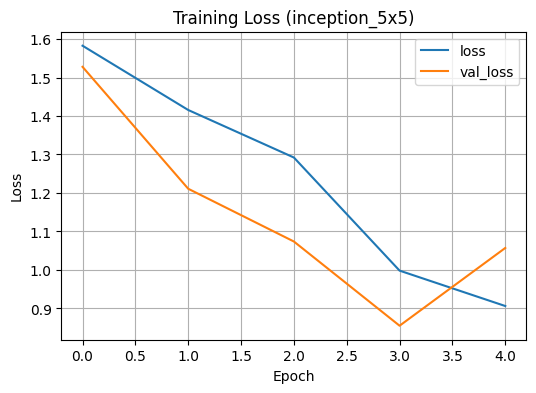

In [18]:
# Load best weights if saved
if os.path.exists("models/inception_5x5.h5"):
    model.load_weights("models/inception_5x5.h5")

# Build arrays of true labels and predicted labels on validation set
y_true = []
y_pred = []

# val_ready yields (inputs, labels)
for batch_inputs, batch_labels in val_ready:
    preds = model.predict(batch_inputs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Print class mapping for clarity
print("Class index -> name mapping:")
for i, cname in train_ds_src.idx_to_class.items():
    print(i, cname)

# Plot loss + val_loss from history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"Training Loss ({APPROACH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Sequential 3D CNN

In [19]:
APPROACH = "sequential"   # options: "inception_3x3", "inception_5x5", "sequential", "slowfast"
EPOCHS = 5
BATCH = 16

# Determine input shape from a single sample
# We use the dataset source object (train_ds_src) to get shapes:
if APPROACH == "slowfast":
    input_shape = (None, 112, 112, 3)  # we'll pass frames counts in builder when building slowfast
else:
    # single stream shape: (T, H, W, C)
    input_shape = (train_ds_src.num_frames, 112, 112, 3)

num_classes = len(train_ds_src.idx_to_class)

builder = VideoModelBuilder(input_shape=input_shape, num_classes=num_classes, base_filters=16)
model = builder.build(approach=APPROACH)
model.summary()

# select appropriate tf datasets for Keras fit
if APPROACH == "slowfast":
    # replace with slowfast datasets if you created them
    train_ready = tf_for_keras(train_tf, slowfast=True)
    val_ready = tf_for_keras(val_tf, slowfast=True)
else:
    train_ready = train_keras
    val_ready = val_keras

# callbacks: light checkpointing
ckpt_cb = tf.keras.callbacks.ModelCheckpoint("models/3D_sequential.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    train_ready,
    validation_data=val_ready,
    epochs=EPOCHS,
    callbacks=[ckpt_cb],
    verbose=2
)

Model: "sequential_3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 video_in (InputLayer)       [(None, 16, 112, 112, 3)  0         
                             ]                                   
                                                                 
 conv3d_55 (Conv3D)          (None, 16, 112, 112, 16)  1312      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 16, 112, 112, 16)  0         
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 8, 56, 56, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_56 (Conv3D)          (None, 8, 56, 56, 32)     13856     
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 8, 56, 56, 32)

Validation accuracy: 0.6212
Confusion matrix (rows=true, cols=pred):
[[11  4  4 11  0]
 [ 5 15  3  0  6]
 [ 2  0 20  5  1]
 [ 0  0  4 21  0]
 [ 0  0  5  0 15]]
Class index -> name mapping:
0 BaseballPitch
1 GolfSwing
2 Lunges
3 PommelHorse
4 Skijet


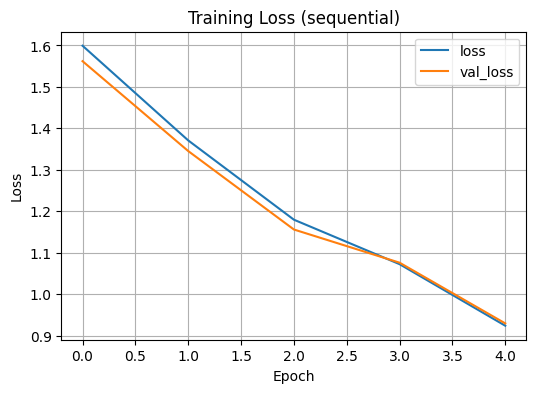

In [20]:
# Load best weights if saved
if os.path.exists("models/3D_sequential.h5"):
    model.load_weights("models/3D_sequential.h5")

# Build arrays of true labels and predicted labels on validation set
y_true = []
y_pred = []

# val_ready yields (inputs, labels)
for batch_inputs, batch_labels in val_ready:
    preds = model.predict(batch_inputs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Print class mapping for clarity
print("Class index -> name mapping:")
for i, cname in train_ds_src.idx_to_class.items():
    print(i, cname)

# Plot loss + val_loss from history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"Training Loss ({APPROACH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Slow-fast Paths 3D CNN

In [23]:
train_ds_sfsrc = VideoDataset(ROOT, split="train", slowfast=True, slow_num_frames=8, fast_num_frames=16)
val_ds_sfsrc   = VideoDataset(ROOT, split="test",   slowfast=True, slow_num_frames=8, fast_num_frames=16)

train_tf_sf = make_tf_dataset(train_ds_sfsrc, batch_size=BATCH, shuffle=True)
val_tf_sf   = make_tf_dataset(val_ds_sfsrc, batch_size=BATCH, shuffle=False)

APPROACH = "slowfast"   # options: "inception_3x3", "inception_5x5", "sequential", "slowfast"
EPOCHS = 5
BATCH = 16

# Determine input shape from a single sample
# We use the dataset source object (train_ds_src) to get shapes:
if APPROACH == "slowfast":
    input_shape = (None, 112, 112, 3)  # we'll pass frames counts in builder when building slowfast
else:
    # single stream shape: (T, H, W, C)
    input_shape = (train_ds_src.num_frames, 112, 112, 3)

num_classes = len(train_ds_src.idx_to_class)

builder = VideoModelBuilder(input_shape=input_shape, num_classes=num_classes, base_filters=16)
model = builder.build(approach=APPROACH)
model.summary()

# select appropriate tf datasets for Keras fit
if APPROACH == "slowfast":
    # replace with slowfast datasets if you created them
    train_ready = tf_for_keras(train_tf_sf, slowfast=True)
    val_ready = tf_for_keras(val_tf_sf, slowfast=True)
else:
    train_ready = train_keras
    val_ready = val_keras

# callbacks: light checkpointing
ckpt_cb = tf.keras.callbacks.ModelCheckpoint("models/3D_slowfastpaths.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    train_ready,
    validation_data=val_ready,
    epochs=EPOCHS,
    callbacks=[ckpt_cb],
    verbose=2
)

✅ Loaded train.npz: 524 samples, 5 classes
✅ Loaded test.npz: 132 samples, 5 classes
Model: "slowfast_simple"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 slow_in (InputLayer)           [(None, 8, 112, 112  0           []                               
                                , 3)]                                                             
                                                                                                  
 fast_in (InputLayer)           [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv3d_66 (Conv3D)             (None, 8, 112, 112,  2624        ['slow_in[0][0]']                

Validation accuracy: 0.6288
Confusion matrix (rows=true, cols=pred):
[[15  9  4  2  0]
 [ 6 20  1  0  2]
 [ 2  0 12 11  3]
 [ 0  0  4 21  0]
 [ 1  2  2  0 15]]
Class index -> name mapping:
0 BaseballPitch
1 GolfSwing
2 Lunges
3 PommelHorse
4 Skijet


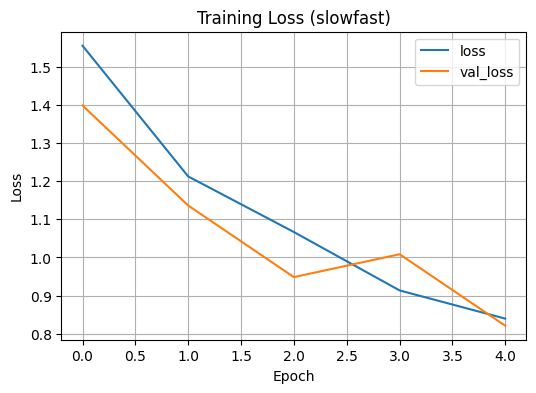

In [24]:
# Load best weights if saved
if os.path.exists("models/3D_slowfastpaths.h5"):
    model.load_weights("models/3D_slowfastpaths.h5")

# Build arrays of true labels and predicted labels on validation set
y_true = []
y_pred = []

# val_ready yields (inputs, labels)
for batch_inputs, batch_labels in val_ready:
    preds = model.predict(batch_inputs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Print class mapping for clarity
print("Class index -> name mapping:")
for i, cname in train_ds_src.idx_to_class.items():
    print(i, cname)

# Plot loss + val_loss from history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"Training Loss ({APPROACH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

#### 1. 3D CNN with InceptionNet (parallel) style 3x3 convs.
Validation accuracy: $0.5833$
$$
\begin{pmatrix}
17 & 12 & 1 & 0 & 0 \\
2 & 24 & 1 & 0 & 2 \\
7 & 2 & 10 & 0 & 9 \\
4 & 0 & 8 & 11 & 2 \\
0 & 2 & 3 & 0 & 15
\end{pmatrix}
$$

***

#### 2. 3D CNN with InceptionNet (parallel) style 5x5 convs.
Validation accuracy: $0.7121$
$$
\begin{pmatrix}
23 & 7 & 0 & 0 & 0 \\
2 & 24 & 3 & 0 & 0 \\
5 & 0 & 15 & 7 & 1 \\
1 & 0 & 5 & 19 & 0 \\
0 & 1 & 6 & 0 & 13
\end{pmatrix}
$$

***

#### 3. 3D CNN with sequential style 3x3 convs.
Validation accuracy: $0.6212$
$$
\begin{pmatrix}
11 & 4 & 4 & 11 & 0 \\
5 & 15 & 3 & 0 & 6 \\
2 & 0 & 20 & 5 & 1 \\
0 & 0 & 4 & 21 & 0 \\
0 & 0 & 5 & 0 & 15
\end{pmatrix}
$$

***

#### 4. 3D CNN with SlowFast paths (3x3 convs).
Validation accuracy: $0.6288$
$$
\begin{pmatrix}
15 & 9 & 4 & 2 & 0 \\
6 & 20 & 1 & 0 & 2 \\
2 & 0 & 12 & 11 & 3 \\
0 & 0 & 4 & 21 & 0 \\
1 & 2 & 2 & 0 & 15
\end{pmatrix}
$$